# Basic model run

## Overview

This notebook provides an overview of how to run a basic simulation of the UK labour market model (i.e. without introducing shocks). 

Throughout the notebook, we use the acronyms SIC for "Standard Industrial Classification", and SOC for "Standard Occupational Classification".

## Import packages

In [1]:
import numpy as np
import pandas as pd
import pickle
import itertools
import time
import os
import copy
import ast
import matplotlib.pyplot as plt
import seaborn as sns

## Set variables related to file names/locations

In [2]:
# Set working directory
home =  os.getcwd()[:-4]

# Choose the variables of interest
regvar = "GORWKR" #geographical region 
sicvar = "Inds07m" #industry (SIC)
socvar = "SC10MMJ" #occupation (SOC)

## Define all required functions

In [3]:
def normalized_transitions(matrix):
    
    """Normalize transition matrix
    
        Inputs:
            matrix = the matrix the user wishes to normalize

        Outputs:
            matrix_temp = matrix containing normalized values
    """
    
    matrix_temp = matrix.copy()   
    matrix_temp = matrix_temp/matrix_temp.sum().sum() #Normalize by dividing all cells by largest cell
    
    return matrix_temp

## Read in all input files, and set all necessary parameters

In [4]:
### Populate data dictionary for input into simulation function
file = open(f'{home}data/20220520 KF PrePub 2001646/activation_dict.txt', "r")
contents = file.read()
adict = ast.literal_eval(contents)
file.close()

file = open(f'{home}data/20220520 KF PrePub 2001646/income_dict_LFS_{regvar}_{sicvar}_{socvar}.txt', "r")
contents = file.read()
idict = ast.literal_eval(contents)
file.close()
   
# Global parameters
N = 3500 # number of workers in the model
# Vacancy rate for initializing the number of positions
num_vac = 800000
num_jobs = 36000000
vacancy_rate = num_vac/num_jobs
P = int(N*(1+vacancy_rate)) # number of positions in the model
granularity = 1 # Granularity for timestep (1 = yearly, 12 = monthly, 52 = weekly, etc.)
job_destruction_rate = 0.0463 # ratio of positions randomly destroyed in 1 iteration (Value from Aron's calibration)
job_creation_rate = job_destruction_rate # ratio of positions randomly created in 1 iteration
PD = int(job_destruction_rate*P) # Get the number of positions to be destroyed
PC = int(job_creation_rate*P) # Get the number of positions to be created
new_worker_init_age = 18 # Intial age of newly created workers
## Survival rates
# Read-in survival rate data from ONS National Life Tables (weighted mean across male and female rates, 2017-2019)
survival_dat = pd.read_excel(f'{home}data/nationallifetable_20172019_wmeans.xlsx')
# Convert to numpy array for computational efficiency
worker_survival_rates = np.asarray(survival_dat.mean_survival)
activation_rate_unemployed = adict['activation_dict']['unemployed_active_weight']/adict['activation_dict']['unemployed_weight'] #0.7923 #Rate at which unemployed workers are activated to perform a job search (set based roughly on 1 - mean economic inactivity rate for 2019, taken from https://www.ons.gov.uk/employmentandlabourmarket/peopleinwork/employmentandemployeetypes/bulletins/employmentintheuk/april2021)
activation_rate_employed = adict['activation_dict']['employed_active_weight']/adict['activation_dict']['employed_weight'] #Ratio controlling the relative frequency with which employed workers are actively searching (as compared to the unemployed) 
sample_size = 1 # Number of candidate positions each active worker will sample within a timestep
gamma = 0.9662 # discount factor for utility calculations
#Global min/max income for generating wages
wage_max = idict['income_dict']['max_annincome']
wage_min = idict['income_dict']['min_annincome']
if wage_min==0:
    wage_min = 0.01
    
#Steady state convergence parameters
ss_threshold = 0.0001 # threshold for convergence to steady state
lag = 50 # Lag value for performing convergence calculation
avg_length = 25 # Breadth of window to average over when performing convergence calculation
avg_length_urates = avg_length # Breadth of window to average over when calculating steady-state unemployment rate
t_ss=0 # Dummy value for the time for the initial flows to stabilise (leave set to 0)

### Read in empirical transition matrices. convert to numpy arrays
reg_trans_mat = pd.read_csv(open(f'{home}data/20220520 KF PrePub 2001646/region_transitiondensity_empirical_LFS_{regvar}_{sicvar}_{socvar}.csv', 'rb'), header=0,index_col=0)
sic_trans_mat = pd.read_csv(open(f'{home}data/20220520 KF PrePub 2001646/sic_transitiondensities_empirical_LFS_{regvar}_{sicvar}_{socvar}.csv', 'rb'), header=0,index_col=0)
soc_trans_mat = pd.read_csv(open(f'{home}data/20220520 KF PrePub 2001646/soc_transitiondensities_empirical_LFS_{regvar}_{sicvar}_{socvar}.csv', 'rb'), header=0,index_col=0)

reg_trans_mat = reg_trans_mat.to_numpy()
sic_trans_mat = sic_trans_mat.to_numpy()
soc_trans_mat = soc_trans_mat.to_numpy()

### Generate category labels for region, SIC, SOC
reg = np.arange(1,reg_trans_mat.shape[0]+1) # Regional category labels
sic = np.arange(1,sic_trans_mat.shape[0]+1) # SIC category labels
soc = np.arange(1,soc_trans_mat.shape[0]+1) # SOC category labels

# Create list of arrays containing all possible values of the integers associated with the regions, SIC sections, and 1-digit SOC codes
iterables = [reg, sic, soc]

# Generate all possible combinations of these (region, SIC, SOC) integers (each corresponding to a potential node)
combos = list(itertools.product(*iterables))

# Create dictionary of (region, SIC, SOC) IDs for these nodes, with associated integer index values
node_dict = {}
for i in range(0,len(combos)):
    node_dict[i] = combos[i] #Key is the numeric index, value is the (reg, sic, soc) triplet
    
n = len(node_dict) #Total number of nodes

# Read in base similarity matrices
node_reg_sim_mat = pickle.load(open(f'{home}data/reg_expanded_similaritymat_LFS.sav', 'rb')) # Region (geographical) similarity
node_sic_sim_mat = pickle.load(open(f'{home}data/sic_expanded_similaritymat_LFS.sav', 'rb')) # SIC (industry) similarity
node_soc_sim_mat = pickle.load(open(f'{home}data/soc_expanded_similaritymat_LFS.sav', 'rb')) # SOC (occupation) similarity

# Get the number of distinct categories for each of region, sic, soc
num_reg = len(reg)
num_sic = len(sic)
num_soc = len(soc)

### Read in simplfied (region, sic division, 1-digit soc) distribution
pos_dist = pd.read_csv(open(f'{home}data/positiondist_reweighted_LFS_{regvar}_{sicvar}_{socvar}.csv'))

### Read in income data for generating wages
inc_dist = pd.read_csv(open(f'{home}data/20220520 KF PrePub 2001646/incomedist_LFS_{regvar}_{sicvar}_{socvar}.csv'))
inc_dist = inc_dist[inc_dist.reg_id!=22].copy()

### Read in age distribution
age_dist = pd.read_csv(open(f'{home}data/age_dist_reweighted_LFS_{regvar}_{sicvar}_{socvar}.csv'), dtype="float64")['AGE']

### Read in consumption preference distribution
cpr_dist = pd.read_csv(open(f'{home}data/consumptionpref_dist_reweighted_LFS_{regvar}_{sicvar}_{socvar}.csv'))['consumption_pref']
# cpr_dist = cpr_dist[cpr_dist>0]

### Populate data dictionary for input into simulation function
with open('%sdata/build_dict_LFS_v1.txt' % home, 'r') as file:
    data = file.read()    
exec(data)

# Create temporary copy of the input data dictionary to be modified during the simulations
input_data_dict_temp = copy.deepcopy(input_data_dict)

## Set up simulation

In [5]:
### Import simulation functions
import ABMrun_LFS_cleaned as sim

steady_state_length = 250 # Number of rounds to estimate transition matrices in the steady state of the model
fitrun_num = 10 # Run of calibration algorithm - leave as is
sim_num = 15 #number of simulations to run in parallel during calibratiion - leave as is

# Generate nu-modified similarity matrices
reg_nu_mat = np.mean(pickle.load(open(f'{home}data/calibration/graddescent_N{N}_reps{sim_num}_GDruns{fitrun_num}_ssthresh{ss_threshold}_nus_reg_scost_mat_LFS.sav', 'rb')), axis=2)
sic_nu_mat = np.mean(pickle.load(open(f'{home}data/calibration/graddescent_N{N}_reps{sim_num}_GDruns{fitrun_num}_ssthresh{ss_threshold}_nus_sic_scost_mat_LFS.sav', 'rb')), axis=2)
soc_nu_mat = np.mean(pickle.load(open(f'{home}data/calibration/graddescent_N{N}_reps{sim_num}_GDruns{fitrun_num}_ssthresh{ss_threshold}_nus_soc_scost_mat_LFS.sav', 'rb')), axis=2)

node_reg_sim_mat_input = np.zeros(node_reg_sim_mat.shape)
node_sic_sim_mat_input = np.zeros(node_sic_sim_mat.shape)
node_soc_sim_mat_input = np.zeros(node_soc_sim_mat.shape)

# Modify similarity matrices using nu-values
for i in range(0,n):
    for j in range(0,n):
        node_reg_sim_mat_input[i,j] = node_reg_sim_mat[i,j]**reg_nu_mat[node_dict[i][0]-1,node_dict[j][0]-1]
        node_sic_sim_mat_input[i,j] = node_sic_sim_mat[i,j]**sic_nu_mat[node_dict[i][1]-1,node_dict[j][1]-1]
        node_soc_sim_mat_input[i,j] = node_soc_sim_mat[i,j]**soc_nu_mat[node_dict[i][2]-1,node_dict[j][2]-1]


input_data_dict_temp['node_reg_sim_mat'] = node_reg_sim_mat_input
input_data_dict_temp['node_sic_sim_mat'] = node_sic_sim_mat_input
input_data_dict_temp['node_soc_sim_mat'] = node_soc_sim_mat_input

## Run simulation

In [6]:
# Run a simulation
model_output = sim.extended_run_simulation(input_data_dict_temp)
# Unpack simulation output
wor_ids,wor_jobs,wor_job_node_ids,wor_ages,wor_consumption_prefs, \
                wor_wages,wor_nonlabour_incomes, \
                wor_unemp_spells,wor_employmentstatus, \
                pos_ids,pos_node_ids,pos_status,pos_worker_ids, \
                pos_reg,pos_sic,pos_soc,pos_wages, \
                statoff_u_rates,statoff_u_durations,statoff_jtj_moves, \
                statoff_num_vacancies,statoff_reg_transition_matrix, \
                statoff_sic_transition_matrix,statoff_soc_transition_matrix, \
                statoff_obj_vals,statoff_active_searches = model_output

# Save model output
pickle.dump(model_output, open('%sdata/model_output_singlerun.sav' % home, 'wb'))

It took 100 timesteps to reach the steady state.
It took 85 additional timesteps for the new flows to stabilise.


## Visualise output

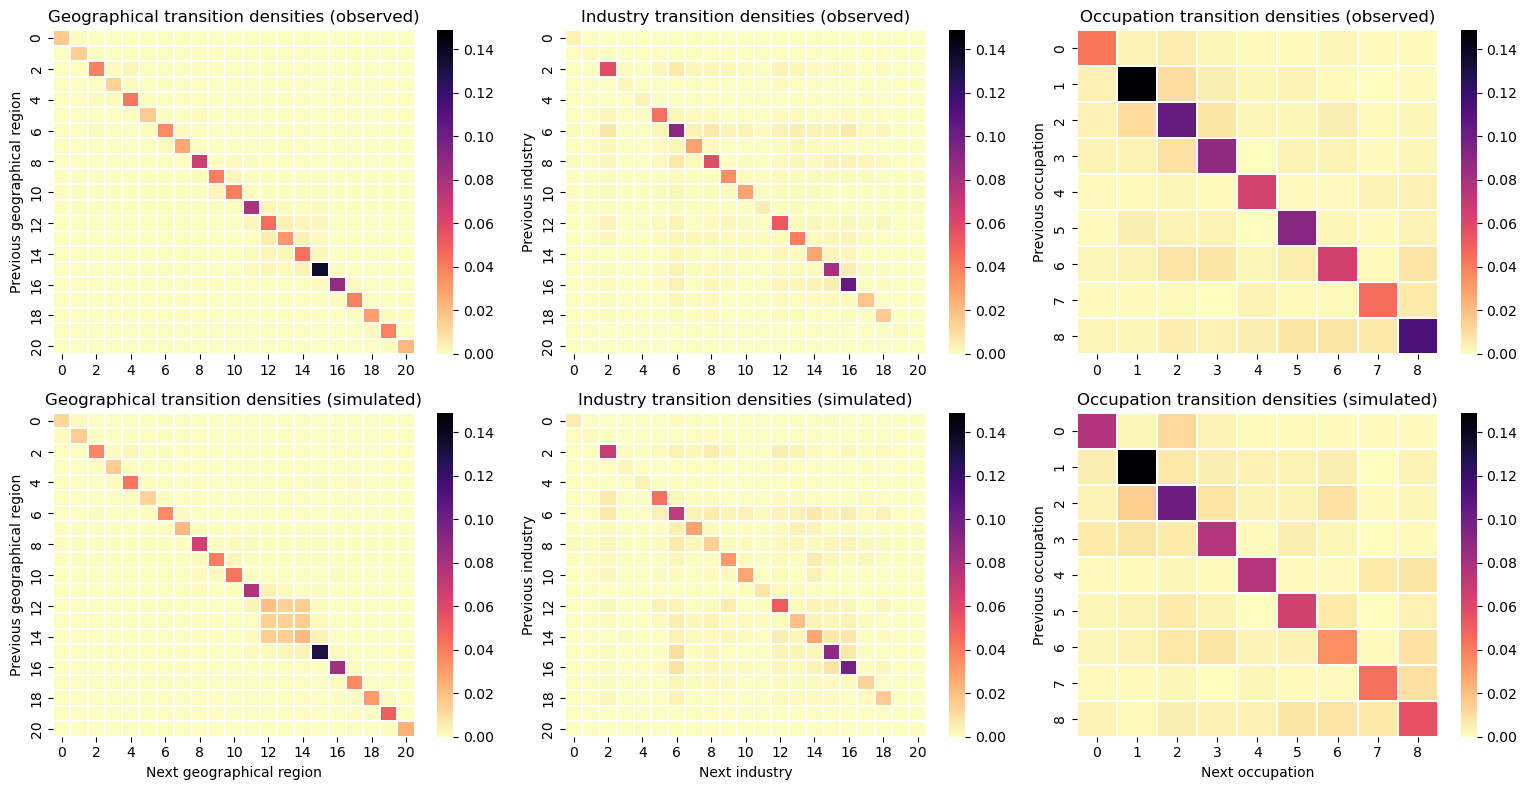

In [7]:
        # Set plotting parameter
        maxval = max([reg_trans_mat.max().max(), sic_trans_mat.max().max(), soc_trans_mat.max().max(), \
                      normalized_transitions(statoff_reg_transition_matrix).max().max(), \
                      normalized_transitions(statoff_reg_transition_matrix).max().max(), \
                      normalized_transitions(statoff_reg_transition_matrix).max().max()])
    
        # Plot of job-to-job transitions
        plt.figure(1, figsize=(15.5,8))

        plt.subplot(231)
        g1=sns.heatmap(reg_trans_mat, linewidth=0.05, cmap="magma_r", vmin=0, vmax=maxval, cbar_ax=None)
        g1.set_ylabel("Previous geographical region")
        g1.set_title("Geographical transition densities (observed)")

        plt.subplot(232)
        g2=sns.heatmap(sic_trans_mat, linewidth=0.05, cmap="magma_r", vmin=0, vmax=maxval, cbar_ax=None)

        g2.set_ylabel("Previous industry")
        g2.set_title("Industry transition densities (observed)")

        plt.subplot(233)
        g3=sns.heatmap(soc_trans_mat, linewidth=0.05, cmap="magma_r", vmin=0, vmax=maxval)
        g3.set_ylabel("Previous occupation")
        g3.set_title("Occupation transition densities (observed)")

        plt.subplot(234)
        g4=sns.heatmap(normalized_transitions(statoff_reg_transition_matrix), linewidth=0.05, cmap="magma_r", vmin=0, vmax=maxval, cbar_ax=None)
        g4.set_xlabel("Next geographical region")
        g4.set_ylabel("Previous geographical region")
        g4.set_title("Geographical transition densities (simulated)")

        plt.subplot(235)
        g5=sns.heatmap(normalized_transitions(statoff_sic_transition_matrix), linewidth=0.05, cmap="magma_r", vmin=0, vmax=maxval, cbar_ax=None)
        g5.set_xlabel("Next industry")
        g5.set_ylabel("Previous industry")
        g5.set_title("Industry transition densities (simulated)")

        plt.subplot(236)
        g6=sns.heatmap(normalized_transitions(statoff_soc_transition_matrix) , linewidth=0.05, cmap="magma_r", vmin=0, vmax=maxval, cbar_ax=None)
        g6.set_xlabel("Next occupation")
        g6.set_ylabel("Previous occupation")
        g6.set_title("Occupation transition densities (simulated)")

        plt.tight_layout()
        plt.show()

## Calculate summary statistics

In [10]:
#Compare empirical transition probability matrix with similarity matrix
# Regions
#Pearson correlation
reg_pearson=(np.corrcoef(np.asarray(reg_trans_mat).flatten(),np.asarray(sim.normalized_transitions(statoff_reg_transition_matrix)).flatten()))
# Frobeneius norm
reg_frobenius=(np.linalg.norm(np.asarray(reg_trans_mat).flatten()-np.asarray(sim.normalized_transitions(statoff_reg_transition_matrix)).flatten()))
# Industries (SIC)
#Pearson correlation
sic_pearson=(np.corrcoef(np.asarray(sic_trans_mat).flatten(),np.asarray(sim.normalized_transitions(statoff_sic_transition_matrix)).flatten()))
# Frobeneius norm
sic_frobenius=(np.linalg.norm(np.asarray(sic_trans_mat).flatten()-np.asarray(sim.normalized_transitions(statoff_sic_transition_matrix)).flatten()))
# Occupation (SOC)
#Pearson correlation
soc_pearson=(np.corrcoef(np.asarray(soc_trans_mat).flatten(),np.asarray(sim.normalized_transitions(statoff_soc_transition_matrix)).flatten()))
# Frobeneius norm
soc_frobenius=(np.linalg.norm(np.asarray(soc_trans_mat).flatten()-np.asarray(sim.normalized_transitions(statoff_soc_transition_matrix)).flatten()))
#Combined (equal weighting)
#Pearson    
comb_pearson = 1/3*(reg_pearson+sic_pearson+soc_pearson)
#Frobenius  
comb_frobenius = 1/3*(reg_frobenius+sic_frobenius+soc_frobenius)

print(f'Pearson correlation between observed and simulated LFNs is {comb_pearson[0,1]}')
print(f'Frobenius norm of differences between observed and simulated LFNs is {comb_frobenius}')

Pearson correlation between observed and simulated LFNs is 0.9591063692177293
Frobenius norm of differences between observed and simulated LFNs is 0.06497264532951971
